<a href="https://colab.research.google.com/github/sukritimahajan35/Semantic-Text-Similarity-SBERT/blob/main/SentenceTransformer_all_MiniLM_L6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Libraries

In [ ]:
!pip install papermill
!pip install datasets sentence-transformers
!pip install xgboost
!pip install scikit-learn
!pip install matplotlib seaborn

Load SNLI Dataset

In [ ]:
from datasets import load_dataset

# Load SNLI dataset
snli = load_dataset('snli')

# Check dataset structure
print(snli)

# Extract premises, hypotheses, and labels
train_data = snli['train']
premises = train_data['premise']
hypotheses = train_data['hypothesis']
labels = train_data['label']  # 0: entailment, 1: neutral, 2: contradiction

# Remove rows with None or missing data
filtered_data = [(p, h, l) for p, h, l in zip(premises, hypotheses, labels) if p and h]
premises, hypotheses, labels = zip(*filtered_data)

print(f"Loaded {len(premises)} sentence pairs.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
})
Loaded 550152 sentence pairs.


Preprocess and Balance Dataset

In [ ]:
from sklearn.utils import resample
import random

# Convert to a list for upsampling
data = list(zip(premises, hypotheses, labels))

# Separate by class labels
entailment = [d for d in data if d[2] == 0]
neutral = [d for d in data if d[2] == 1]
contradiction = [d for d in data if d[2] == 2]

# Upsample the minority classes (optional)
max_size = max(len(entailment), len(neutral), len(contradiction))

entailment_upsampled = resample(entailment, replace=True, n_samples=max_size, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_size, random_state=42)
contradiction_upsampled = resample(contradiction, replace=True, n_samples=max_size, random_state=42)

# Combine the classes back together
balanced_data = entailment_upsampled + neutral_upsampled + contradiction_upsampled

# Shuffle the dataset
random.shuffle(balanced_data)

# Unzip back to premises, hypotheses, and labels
premises, hypotheses, labels = zip(*balanced_data)

print(f"Loaded {len(premises)} balanced sentence pairs.")

Loaded 550248 balanced sentence pairs.


Sentence Embeddings with Sentence-BERT

In [ ]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for both premises and hypotheses
premise_embeddings = model.encode(premises, show_progress_bar=True)
hypothesis_embeddings = model.encode(hypotheses, show_progress_bar=True)

print(f"Premise Embedding Shape: {premise_embeddings.shape}")
print(f"Hypothesis Embedding Shape: {hypothesis_embeddings.shape}")

Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Batches:   0%|          | 0/17196 [00:00<?, ?it/s]

Premise Embedding Shape: (550248, 384)
Hypothesis Embedding Shape: (550248, 384)


Similarity Analysis (Cosine Similarity)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Example: Find similarity between the first premise and all hypotheses
similarity_scores = cosine_similarity([premise_embeddings[0]], hypothesis_embeddings)

# Retrieve top-5 most similar hypotheses
top_indices = similarity_scores[0].argsort()[-5:][::-1]
print("Top 5 Similar Hypotheses:")
for idx in top_indices:
    print(f"Score: {similarity_scores[0][idx]:.2f}, Hypothesis: {hypotheses[idx]}")

Top 5 Similar Hypotheses:
Score: 0.90, Hypothesis: A surfer is in the tunnel part of the wave.
Score: 0.84, Hypothesis: A surfer rides a wave.
Score: 0.84, Hypothesis: A surfer rides a wave.
Score: 0.84, Hypothesis: A surfer rides a wave.
Score: 0.84, Hypothesis: A surfer rides a wave.


Semantic Analysis - Sentiment or Similarity Analysis

In [ ]:
# Example: Perform semantic similarity analysis between two sentences
sentence_1 = "A person is walking in the park."
sentence_2 = "Someone is strolling in a garden."

# Get embeddings
embedding_1 = model.encode(sentence_1)
embedding_2 = model.encode(sentence_2)

# Compute cosine similarity
similarity = cosine_similarity([embedding_1], [embedding_2])
print(f"Semantic similarity score between the two sentences: {similarity[0][0]:.2f}")

Semantic similarity score between the two sentences: 0.57


Question-Answer Pair Generation (Using Premise and Hypothesis)

In [ ]:
# Example: Generate Q&A pairs based on premise-hypothesis
def generate_question_answer(premise, hypothesis):
    # Simple rule: extract a question from the premise and check the relationship with the hypothesis
    question = f"Where is {premise.split()[0]}?"
    answer = "On the mat" if "on a mat" in hypothesis else "Not on a mat"
    return question, answer

# Generate Q&A for first example
question, answer = generate_question_answer(premises[0], hypotheses[0])
print(f"Generated Question: {question}")
print(f"Generated Answer: {answer}")

Generated Question: Where is A?
Generated Answer: Not on a mat


Model Evaluation with XGBoost (Classification)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Combine embeddings (premise and hypothesis embeddings)
combined_embeddings = [np.concatenate((p, h)) for p, h in zip(premise_embeddings, hypothesis_embeddings)]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, labels, test_size=0.2, random_state=42)

# Train an XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:57:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Accuracy: 0.75


Clustering: KMeans Clustering with PCA Visualization

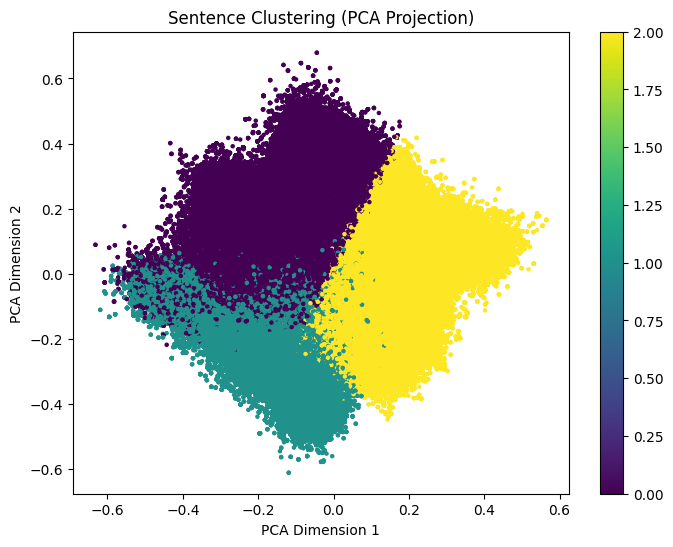

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(premise_embeddings)

# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(premise_embeddings)

# Plotting the clusters with PCA reduction
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("Sentence Clustering (PCA Projection)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar()
plt.show()

Query-Based Information Retrieval (With Semantic Matching)

In [ ]:
# Get query input from the user
query = input("Enter your query sentence: ")  # Prompting for input

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: Will you have a cup of coffee?

Top Matches for Query (Diverse Results):
Score: 0.78, Sentence: Are you coming with me for a cup of coffee?
Score: 0.53, Sentence: A woman walking and drinking coffee.
Score: 0.50, Sentence: Man with cupcakes and coffee contemplating the statement "who are you?"
Score: 0.50, Sentence: A woman is drinking her coffee.
Score: 0.50, Sentence: A woman with glasses drinks coffee at a cafe.


In [ ]:
# Get query input from the user
query = input("Enter your query sentence: ")

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: I am watching a movie.

Top Matches for Query (Diverse Results):
Score: 0.52, Sentence: a line waiting to get into a movie
Score: 0.50, Sentence: The marquee of movies now playing.
Score: 0.48, Sentence: A lady bowling while watching a movie.
Score: 0.43, Sentence: People watching an interesting thing.
Score: 0.42, Sentence: Three people walking out of a movie.


In [ ]:
# Get query input from the user
query = input("Enter your query sentence: ")

# Generate the query embedding
query_embedding = model.encode(query)

# Compute similarity scores between the query and all premises
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Ensure the premise and similarity scores align
assert len(premises) == len(similarity_scores[0]), "Premises length and similarity scores length mismatch!"

# Retrieve top N most similar sentences with diversity
top_n = 5
retrieved_indices = set()
top_results = []

for idx in similarity_scores[0].argsort()[::-1]:
    if idx < len(premises) and premises[idx] not in retrieved_indices:
        top_results.append((similarity_scores[0][idx], premises[idx]))
        retrieved_indices.add(premises[idx])
    if len(top_results) >= top_n:
        break

# Display top matches
print("\nTop Matches for Query (Diverse Results):")
for score, sentence in top_results:
    print(f"Score: {score:.2f}, Sentence: {sentence}")

Enter your query sentence: Today is a sunny day.

Top Matches for Query (Diverse Results):
Score: 0.79, Sentence: A normal sunny day in a big city.
Score: 0.76, Sentence: People outside on a sunny day.
Score: 0.72, Sentence: Group of people on a sunny day.
Score: 0.71, Sentence: People pass time outside on a sunny day.
Score: 0.67, Sentence: People walk down the street on a sunny day.


In [ ]:
# Print some premises to verify
print(f"First 5 premises:\n {premises[:5]}")

# Ensure you are encoding the correct data
premise_embeddings = model.encode(premises, show_progress_bar=True)
query_embedding = model.encode(query)  # Encoding only the query

# Verify lengths after encoding
print(f"Length of encoded premises: {len(premise_embeddings)}")
print(f"Length of similarity scores: {len(similarity_scores[0])}")

First 5 premises:
 ('Two young Asian women buy food from a Japanese food establishment.', 'A man in a green t-shirt and long tan apron hacks apart the carcass of a cow while another man hoses away the blood.', 'Two young females talk and text as they stare into the distance.', 'The family is enjoying their dinner.', 'Futuristic bike rider wins the riding in place championship.')


Batches:   0%|          | 0/10869 [00:00<?, ?it/s]

Length of encoded premises: 347799
Length of similarity scores: 347799


In [ ]:
# Assuming you have already defined the similarity scores after encoding
similarity_scores = cosine_similarity([query_embedding], premise_embeddings)

# Verify lengths
print(f"Length of premises: {len(premises)}")
print(f"Length of similarity_scores: {len(similarity_scores[0])}")

Length of premises: 347799
Length of similarity_scores: 347799


Calculating the Difference in Embeddings Between Premise and Hypothesis

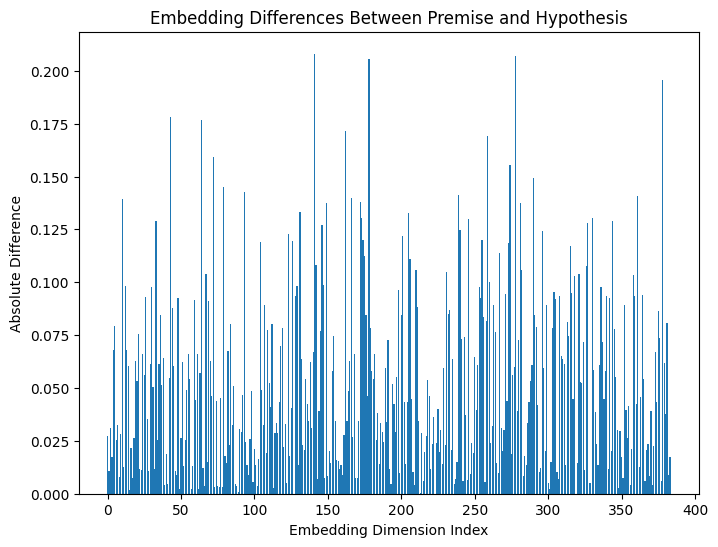

Embedding Difference Example (Premise-Hypothesis):
[2.71896832e-02 1.06033860e-02 3.12202517e-02 1.75011009e-02
 6.81758523e-02 7.95084313e-02 2.56278515e-02 3.26407328e-02
 7.92897120e-03 2.81233527e-02 1.39233112e-01 1.26292035e-02
 9.81289893e-02 6.80265576e-02 6.02740720e-02 1.64696388e-03
 2.15285718e-02 7.60896318e-03 2.65256092e-02 6.26218468e-02
 5.32571189e-02 7.55143389e-02 1.14985090e-02 1.11118779e-02
 6.62375838e-02 5.61713427e-02 9.29766893e-02 3.54588479e-02
 1.05565032e-02 6.12956509e-02 9.75620076e-02 5.03599197e-02
 1.16051603e-02 1.28768399e-01 2.54244786e-02 6.11689799e-02
 8.43038559e-02 5.12210019e-02 6.41970709e-02 3.92785296e-03
 1.85711216e-02 4.79708239e-03 5.46129011e-02 1.78100258e-01
 8.78810138e-02 6.04690462e-02 1.07304566e-02 8.93805176e-03
 9.25457776e-02 2.27629207e-03 2.65118126e-02 6.21913932e-02
 1.28833987e-02 2.52384748e-02 4.90931608e-02 6.59298450e-02
 5.41108251e-02 2.36720592e-03 1.31565686e-02 9.16339681e-02
 4.44900654e-02 6.58996105e-02 2.0

In [ ]:
import numpy as np

# Example: Calculate the difference in embeddings between premise and hypothesis
embedding_diff = np.abs(premise_embeddings[0] - hypothesis_embeddings[0])

# Visualize the embedding differences for the first sentence pair
plt.figure(figsize=(8, 6))
plt.bar(range(len(embedding_diff)), embedding_diff)
plt.title("Embedding Differences Between Premise and Hypothesis")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Absolute Difference")
plt.show()

print("Embedding Difference Example (Premise-Hypothesis):")
print(embedding_diff)

Visualizing Sentence Embedding Distributions

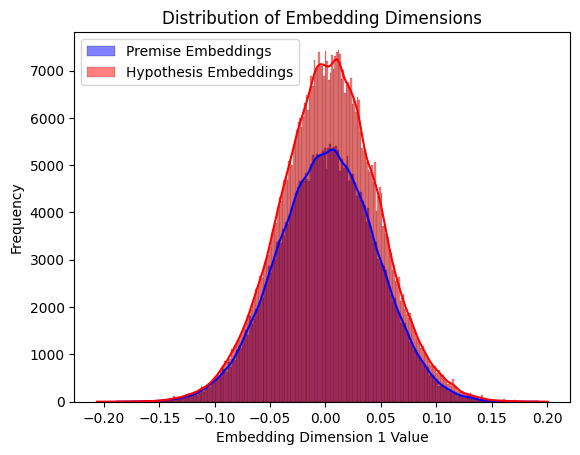

In [ ]:
import seaborn as sns

# Visualize the distribution of the first dimension of premise embeddings
sns.histplot(premise_embeddings[:, 0], kde=True, color='blue', label='Premise Embeddings')
sns.histplot(hypothesis_embeddings[:, 0], kde=True, color='red', label='Hypothesis Embeddings')
plt.legend()
plt.title("Distribution of Embedding Dimensions")
plt.xlabel("Embedding Dimension 1 Value")
plt.ylabel("Frequency")
plt.show()